# Assignment 2 - Question 1
### Heather Chen
#### 1. Parallel Web Scraping

In [1]:
import requests
import dataset
import re
import pywren
import time
import numpy as np
from datetime import datetime
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse

In [2]:
#Original Serial Solution
db = dataset.connect('sqlite:///books.db')

base_url = 'http://books.toscrape.com/'

def scrape_books(html_soup, url):
    for book in html_soup.select('article.product_pod'):
        # For now, we'll only store the books url
        book_url = book.find('h3').find('a').get('href')
        book_url = urljoin(url, book_url)
        path = urlparse(book_url).path
        book_id = path.split('/')[2]
        # Upsert tries to update first and then insert instead
        db['books'].upsert({'book_id' : book_id,
                            'last_seen' : datetime.now()
                            }, ['book_id'])

def scrape_book(html_soup, book_id):
    main = html_soup.find(class_='product_main')
    book = {}
    book['book_id'] = book_id
    book['title'] = main.find('h1').get_text(strip=True)
    book['price'] = main.find(class_='price_color').get_text(strip=True)
    book['stock'] = main.find(class_='availability').get_text(strip=True)
    book['rating'] = ' '.join(main.find(class_='star-rating') \
                        .get('class')).replace('star-rating', '').strip()
    book['img'] = html_soup.find(class_='thumbnail').find('img').get('src')
    desc = html_soup.find(id='product_description')
    book['description'] = ''
    if desc:
        book['description'] = desc.find_next_sibling('p') \
                                  .get_text(strip=True)
    book_product_table = html_soup.find(text='Product Information').find_next('table')
    for row in book_product_table.find_all('tr'):
        header = row.find('th').get_text(strip=True)
        # Since we'll use the header as a column, clean it a bit
        # to make sure SQLite will accept it
        header = re.sub('[^a-zA-Z]+', '_', header)
        value = row.find('td').get_text(strip=True)
        book[header] = value
    db['book_info'].upsert(book, ['book_id'])

# Scrape the pages in the catalogue
url = base_url
#inp = input('Do you wish to re-scrape the catalogue (y/n)? ')
while True:
    print('Now scraping page:', url)
    r = requests.get(url)
    html_soup = BeautifulSoup(r.text, 'html.parser')
    scrape_books(html_soup, url)
    # Is there a next page?
    next_a = html_soup.select('li.next > a')
    if not next_a or not next_a[0].get('href'):
        break
    url = urljoin(url, next_a[0].get('href'))

# Now scrape book by book, oldest first
start_time_serial = time.time()
books = db['books'].find(order_by=['last_seen'])
for book in books:
    book_id = book['book_id']
    book_url = base_url + 'catalogue/{}'.format(book_id)
    print('Now scraping book:', book_url)
    r = requests.get(book_url)
    r.encoding = 'utf-8'
    html_soup = BeautifulSoup(r.text, 'html.parser')
    scrape_book(html_soup, book_id)
    # Update the last seen timestamp
    db['books'].upsert({'book_id' : book_id,
                        'last_seen' : datetime.now()
                        }, ['book_id'])
used_time_serial = time.time() - start_time_serial

Now scraping page: http://books.toscrape.com/
Now scraping page: http://books.toscrape.com/catalogue/page-2.html
Now scraping page: http://books.toscrape.com/catalogue/page-3.html
Now scraping page: http://books.toscrape.com/catalogue/page-4.html
Now scraping page: http://books.toscrape.com/catalogue/page-5.html
Now scraping page: http://books.toscrape.com/catalogue/page-6.html
Now scraping page: http://books.toscrape.com/catalogue/page-7.html
Now scraping page: http://books.toscrape.com/catalogue/page-8.html
Now scraping page: http://books.toscrape.com/catalogue/page-9.html
Now scraping page: http://books.toscrape.com/catalogue/page-10.html
Now scraping page: http://books.toscrape.com/catalogue/page-11.html
Now scraping page: http://books.toscrape.com/catalogue/page-12.html
Now scraping page: http://books.toscrape.com/catalogue/page-13.html
Now scraping page: http://books.toscrape.com/catalogue/page-14.html
Now scraping page: http://books.toscrape.com/catalogue/page-15.html
Now scrapi

Now scraping book: http://books.toscrape.com/catalogue/tsubasa-world-chronicle-2-tsubasa-world-chronicle-2_949
Now scraping book: http://books.toscrape.com/catalogue/throwing-rocks-at-the-google-bus-how-growth-became-the-enemy-of-prosperity_948
Now scraping book: http://books.toscrape.com/catalogue/this-one-summer_947
Now scraping book: http://books.toscrape.com/catalogue/thirst_946
Now scraping book: http://books.toscrape.com/catalogue/the-torch-is-passed-a-harding-family-story_945
Now scraping book: http://books.toscrape.com/catalogue/the-secret-of-dreadwillow-carse_944
Now scraping book: http://books.toscrape.com/catalogue/the-pioneer-woman-cooks-dinnertime-comfort-classics-freezer-food-16-minute-meals-and-other-delicious-ways-to-solve-supper_943
Now scraping book: http://books.toscrape.com/catalogue/the-past-never-ends_942
Now scraping book: http://books.toscrape.com/catalogue/the-natural-history-of-us-the-fine-art-of-pretending-2_941
Now scraping book: http://books.toscrape.com/ca

Now scraping book: http://books.toscrape.com/catalogue/unqualified-how-god-uses-broken-people-to-do-big-things_873
Now scraping book: http://books.toscrape.com/catalogue/you-are-what-you-love-the-spiritual-power-of-habit_872
Now scraping book: http://books.toscrape.com/catalogue/william-shakespeares-star-wars-verily-a-new-hope-william-shakespeares-star-wars-4_871
Now scraping book: http://books.toscrape.com/catalogue/tuesday-nights-in-1980_870
Now scraping book: http://books.toscrape.com/catalogue/tracing-numbers-on-a-train_869
Now scraping book: http://books.toscrape.com/catalogue/throne-of-glass-throne-of-glass-1_868
Now scraping book: http://books.toscrape.com/catalogue/thomas-jefferson-and-the-tripoli-pirates-the-forgotten-war-that-changed-american-history_867
Now scraping book: http://books.toscrape.com/catalogue/thirteen-reasons-why_866
Now scraping book: http://books.toscrape.com/catalogue/the-white-cat-and-the-monk-a-retelling-of-the-poem-pangur-ban_865
Now scraping book: http:

Now scraping book: http://books.toscrape.com/catalogue/anonymous_790
Now scraping book: http://books.toscrape.com/catalogue/amy-meets-the-saints-and-sages_789
Now scraping book: http://books.toscrape.com/catalogue/amid-the-chaos_788
Now scraping book: http://books.toscrape.com/catalogue/amatus_787
Now scraping book: http://books.toscrape.com/catalogue/agnostic-a-spirited-manifesto_786
Now scraping book: http://books.toscrape.com/catalogue/zealot-the-life-and-times-of-jesus-of-nazareth_785
Now scraping book: http://books.toscrape.com/catalogue/you-you-1_784
Now scraping book: http://books.toscrape.com/catalogue/wonder-woman-earth-one-volume-one-wonder-woman-earth-one-1_783
Now scraping book: http://books.toscrape.com/catalogue/wild-swans_782
Now scraping book: http://books.toscrape.com/catalogue/why-the-right-went-wrong-conservatism-from-goldwater-to-the-tea-party-and-beyond_781
Now scraping book: http://books.toscrape.com/catalogue/whole-lotta-creativity-going-on-60-fun-and-unusual-exe

Now scraping book: http://books.toscrape.com/catalogue/i-know-what-im-doing-and-other-lies-i-tell-myself-dispatches-from-a-life-under-construction_704
Now scraping book: http://books.toscrape.com/catalogue/i-am-pilgrim-pilgrim-1_703
Now scraping book: http://books.toscrape.com/catalogue/hyperbole-and-a-half-unfortunate-situations-flawed-coping-mechanisms-mayhem-and-other-things-that-happened_702
Now scraping book: http://books.toscrape.com/catalogue/hush-hush-hush-hush-1_701
Now scraping book: http://books.toscrape.com/catalogue/hold-your-breath-search-and-rescue-1_700
Now scraping book: http://books.toscrape.com/catalogue/hamilton-the-revolution_699
Now scraping book: http://books.toscrape.com/catalogue/greek-mythic-history_698
Now scraping book: http://books.toscrape.com/catalogue/god-the-most-unpleasant-character-in-all-fiction_697
Now scraping book: http://books.toscrape.com/catalogue/glory-over-everything-beyond-the-kitchen-house_696
Now scraping book: http://books.toscrape.com/ca

Now scraping book: http://books.toscrape.com/catalogue/hide-away-eve-duncan-20_620
Now scraping book: http://books.toscrape.com/catalogue/furiously-happy-a-funny-book-about-horrible-things_619
Now scraping book: http://books.toscrape.com/catalogue/everyday-italian-125-simple-and-delicious-recipes_618
Now scraping book: http://books.toscrape.com/catalogue/equal-is-unfair-americas-misguided-fight-against-income-inequality_617
Now scraping book: http://books.toscrape.com/catalogue/eleanor-park_616
Now scraping book: http://books.toscrape.com/catalogue/dirty-dive-bar-1_615
Now scraping book: http://books.toscrape.com/catalogue/can-you-keep-a-secret-fear-street-relaunch-4_614
Now scraping book: http://books.toscrape.com/catalogue/boar-island-anna-pigeon-19_613
Now scraping book: http://books.toscrape.com/catalogue/a-paris-apartment_612
Now scraping book: http://books.toscrape.com/catalogue/a-la-mode-120-recipes-in-60-pairings-pies-tarts-cakes-crisps-and-more-topped-with-ice-cream-gelato-fro

Now scraping book: http://books.toscrape.com/catalogue/out-of-print-city-lights-spotlight-no-14_536
Now scraping book: http://books.toscrape.com/catalogue/my-life-next-door-my-life-next-door_535
Now scraping book: http://books.toscrape.com/catalogue/millers-valley_534
Now scraping book: http://books.toscrape.com/catalogue/mans-search-for-meaning_533
Now scraping book: http://books.toscrape.com/catalogue/love-that-boy-what-two-presidents-eight-road-trips-and-my-son-taught-me-about-a-parents-expectations_532
Now scraping book: http://books.toscrape.com/catalogue/living-forward-a-proven-plan-to-stop-drifting-and-get-the-life-you-want_531
Now scraping book: http://books.toscrape.com/catalogue/les-fleurs-du-mal_530
Now scraping book: http://books.toscrape.com/catalogue/left-behind-left-behind-1_529
Now scraping book: http://books.toscrape.com/catalogue/kill-em-and-leave-searching-for-james-brown-and-the-american-soul_528
Now scraping book: http://books.toscrape.com/catalogue/kierkegaard-a-c

Now scraping book: http://books.toscrape.com/catalogue/the-sound-of-love_455
Now scraping book: http://books.toscrape.com/catalogue/the-rise-and-fall-of-the-third-reich-a-history-of-nazi-germany_454
Now scraping book: http://books.toscrape.com/catalogue/the-perks-of-being-a-wallflower_453
Now scraping book: http://books.toscrape.com/catalogue/the-mysterious-affair-at-styles-hercule-poirot-1_452
Now scraping book: http://books.toscrape.com/catalogue/the-man-who-mistook-his-wife-for-a-hat-and-other-clinical-tales_451
Now scraping book: http://books.toscrape.com/catalogue/the-makings-of-a-fatherless-child_450
Now scraping book: http://books.toscrape.com/catalogue/the-joy-of-cooking_449
Now scraping book: http://books.toscrape.com/catalogue/the-invention-of-wings_448
Now scraping book: http://books.toscrape.com/catalogue/the-hobbit-middle-earth-universe_447
Now scraping book: http://books.toscrape.com/catalogue/the-great-railway-bazaar_446
Now scraping book: http://books.toscrape.com/catal

Now scraping book: http://books.toscrape.com/catalogue/data-a-love-story-how-i-gamed-online-dating-to-meet-my-match_367
Now scraping book: http://books.toscrape.com/catalogue/critique-of-pure-reason_366
Now scraping book: http://books.toscrape.com/catalogue/booked_365
Now scraping book: http://books.toscrape.com/catalogue/blue-lily-lily-blue-the-raven-cycle-3_364
Now scraping book: http://books.toscrape.com/catalogue/approval-junkie-adventures-in-caring-too-much_363
Now scraping book: http://books.toscrape.com/catalogue/an-abundance-of-katherines_362
Now scraping book: http://books.toscrape.com/catalogue/americas-war-for-the-greater-middle-east-a-military-history_361
Now scraping book: http://books.toscrape.com/catalogue/alight-the-generations-trilogy-2_360
Now scraping book: http://books.toscrape.com/catalogue/a-girls-guide-to-moving-on-new-beginnings-2_359
Now scraping book: http://books.toscrape.com/catalogue/a-game-of-thrones-a-song-of-ice-and-fire-1_358
Now scraping book: http://b

Now scraping book: http://books.toscrape.com/catalogue/the-thing-about-jellyfish_283
Now scraping book: http://books.toscrape.com/catalogue/the-stand_282
Now scraping book: http://books.toscrape.com/catalogue/the-smitten-kitchen-cookbook_281
Now scraping book: http://books.toscrape.com/catalogue/the-silkworm-cormoran-strike-2_280
Now scraping book: http://books.toscrape.com/catalogue/the-sandman-vol-3-dream-country-the-sandman-volumes-3_279
Now scraping book: http://books.toscrape.com/catalogue/the-rose-the-dagger-the-wrath-and-the-dawn-2_278
Now scraping book: http://books.toscrape.com/catalogue/the-road-to-little-dribbling-adventures-of-an-american-in-britain-notes-from-a-small-island-2_277
Now scraping book: http://books.toscrape.com/catalogue/the-rise-of-theodore-roosevelt-theodore-roosevelt-1_276
Now scraping book: http://books.toscrape.com/catalogue/the-restaurant-at-the-end-of-the-universe-hitchhikers-guide-to-the-galaxy-2_275
Now scraping book: http://books.toscrape.com/catalog

Now scraping book: http://books.toscrape.com/catalogue/night-the-night-trilogy-1_199
Now scraping book: http://books.toscrape.com/catalogue/neither-here-nor-there-travels-in-europe_198
Now scraping book: http://books.toscrape.com/catalogue/naked_197
Now scraping book: http://books.toscrape.com/catalogue/morning-star-red-rising-3_196
Now scraping book: http://books.toscrape.com/catalogue/miracles-from-heaven-a-little-girl-her-journey-to-heaven-and-her-amazing-story-of-healing_195
Now scraping book: http://books.toscrape.com/catalogue/midnight-riot-peter-grant-rivers-of-london-books-1_194
Now scraping book: http://books.toscrape.com/catalogue/me-talk-pretty-one-day_193
Now scraping book: http://books.toscrape.com/catalogue/manuscript-found-in-accra_192
Now scraping book: http://books.toscrape.com/catalogue/lust-wonder_191
Now scraping book: http://books.toscrape.com/catalogue/lila-gilead-3_190
Now scraping book: http://books.toscrape.com/catalogue/life-the-universe-and-everything-hitchhi

Now scraping book: http://books.toscrape.com/catalogue/the-course-of-love_109
Now scraping book: http://books.toscrape.com/catalogue/sugar-rush-offensive-line-2_108
Now scraping book: http://books.toscrape.com/catalogue/saga-volume-2-saga-collected-editions-2_107
Now scraping book: http://books.toscrape.com/catalogue/run-spot-run-the-ethics-of-keeping-pets_106
Now scraping book: http://books.toscrape.com/catalogue/new-moon-twilight-2_105
Now scraping book: http://books.toscrape.com/catalogue/life_104
Now scraping book: http://books.toscrape.com/catalogue/kindle-paperwhite-users-guide_103
Now scraping book: http://books.toscrape.com/catalogue/h-is-for-hawk_102
Now scraping book: http://books.toscrape.com/catalogue/girl-online-on-tour-girl-online-2_101
Now scraping book: http://books.toscrape.com/catalogue/fruits-basket-vol-2-fruits-basket-2_100
Now scraping book: http://books.toscrape.com/catalogue/diary-of-a-minecraft-zombie-book-1-a-scare-of-a-dare-an-unofficial-minecraft-book_99
Now 

Now scraping book: http://books.toscrape.com/catalogue/choosing-our-religion-the-spiritual-lives-of-americas-nones_14
Now scraping book: http://books.toscrape.com/catalogue/charlie-and-the-chocolate-factory-charlie-bucket-1_13
Now scraping book: http://books.toscrape.com/catalogue/charitys-cross-charles-towne-belles-4_12
Now scraping book: http://books.toscrape.com/catalogue/bright-lines_11
Now scraping book: http://books.toscrape.com/catalogue/bridget-joness-diary-bridget-jones-1_10
Now scraping book: http://books.toscrape.com/catalogue/bounty-colorado-mountain-7_9
Now scraping book: http://books.toscrape.com/catalogue/blood-defense-samantha-brinkman-1_8
Now scraping book: http://books.toscrape.com/catalogue/bleach-vol-1-strawberry-and-the-soul-reapers-bleach-1_7
Now scraping book: http://books.toscrape.com/catalogue/beyond-good-and-evil_6
Now scraping book: http://books.toscrape.com/catalogue/alice-in-wonderland-alices-adventures-in-wonderland-1_5
Now scraping book: http://books.tosc

In [3]:
print("Used time for serial solution:", used_time_serial)

Used time for serial solution: 1957.580626964569


(Sorry I haven't perceived it would take so much time) The total time cost for serial solution is 1957 seconds, approximately 33 minutes.

In [4]:
#Parallel Solution
#Use the same function to scrape webpages from url
# Scrape the pages in the catalogue
url = base_url
start_time_parallel = time.time()
while True:
    print('Now scraping page:', url)
    r = requests.get(url)
    html_soup = BeautifulSoup(r.text, 'html.parser')
    scrape_books(html_soup, url)
    # Is there a next page?
    next_a = html_soup.select('li.next > a')
    if not next_a or not next_a[0].get('href'):
        break
    url = urljoin(url, next_a[0].get('href'))

Now scraping page: http://books.toscrape.com/
Now scraping page: http://books.toscrape.com/catalogue/page-2.html
Now scraping page: http://books.toscrape.com/catalogue/page-3.html
Now scraping page: http://books.toscrape.com/catalogue/page-4.html
Now scraping page: http://books.toscrape.com/catalogue/page-5.html
Now scraping page: http://books.toscrape.com/catalogue/page-6.html
Now scraping page: http://books.toscrape.com/catalogue/page-7.html
Now scraping page: http://books.toscrape.com/catalogue/page-8.html
Now scraping page: http://books.toscrape.com/catalogue/page-9.html
Now scraping page: http://books.toscrape.com/catalogue/page-10.html
Now scraping page: http://books.toscrape.com/catalogue/page-11.html
Now scraping page: http://books.toscrape.com/catalogue/page-12.html
Now scraping page: http://books.toscrape.com/catalogue/page-13.html
Now scraping page: http://books.toscrape.com/catalogue/page-14.html
Now scraping page: http://books.toscrape.com/catalogue/page-15.html
Now scrapi

In [5]:
#Find the optimal batch size:
#First, set the number of books in the batch to scrape scales from 5 to 100: (5, 10, 15,...)
batch_counts = np.arange(5, 105, 5)
count = 0
book_batch_lists = []
book_batch = []
#Second, for book in books, create a list of lists of books, each smaller list has the exact amount of books as batch
#size in it
for batch_count in batch_counts:
    book_batch_list = []
    books = db['books'].find(order_by=['last_seen'])
    for book in books:
        count = count + 1
        book_id = book['book_id']
        book_url = base_url + 'catalogue/{}'.format(book_id)
        book_batch.append([book_id, book_url])
        #If there are enough book in one book batch
        if count == batch_count:
            book_batch_list.append(book_batch)
            count = 0
            book_batch = []
    #print(book_batch_list)
    book_batch_lists.append(book_batch_list)
#So this book_batch_lists contain a series of lists, each list constitute of a batch_count number and
#the corresponding batch_list

In [7]:
#Define a AWS Lambda function to scrape each book from the batch
def scrape_book_urls(book_batch):
    scrapped_books = []
    for book in book_batch:
        #Book url is the second item in the list
        book_url = book[1]
        #print('Now scraping book:', book_url)
        r = requests.get(book_url)
        r.encoding = 'utf-8'
        scrapped_books.append([book[0], r.text])
    #Return a list of book id and scrapped text
    return scrapped_books

#Calculate the time for each batch_size
# Set up a pywren executor and map the list of book batches
time_results_list = []
num = 0
for batch_count in batch_counts:
    start_time_parallel = time.time()
    book_batch_list = book_batch_lists[num]
    #print("Length in batch list:", len(book_batch_list[1]))
    #print("Batch Count:", batch_count)
    pwex = pywren.default_executor()
    book_batch_results = pywren.get_all_results(pwex.map(scrape_book_urls, book_batch_list))
    for book_list in book_batch_results:
        for book in book_list:
            book_id = book[0]
            book_text = book[1]
            html_soup = BeautifulSoup(book_text, 'html.parser')
            scrape_book(html_soup, book_id)
            # Update the last seen timestamp
            db['books'].upsert({'book_id' : book_id,'last_seen' : datetime.now()}, ['book_id'])
    used_time_parallel = time.time() - start_time_parallel
    print("Batch Count:", batch_count, ", Used Time:", used_time_parallel)
    time_results_list.append([batch_count, used_time_parallel])
    num = num + 1

Batch Count: 5 , Used Time: 47.13492393493652
Batch Count: 10 , Used Time: 46.72499203681946
Batch Count: 15 , Used Time: 43.81148815155029
Batch Count: 20 , Used Time: 39.05330491065979
Batch Count: 25 , Used Time: 43.26292300224304
Batch Count: 30 , Used Time: 36.68480205535889
Batch Count: 35 , Used Time: 38.052515745162964
Batch Count: 40 , Used Time: 43.88878107070923
Batch Count: 45 , Used Time: 48.68405199050903
Batch Count: 50 , Used Time: 37.06578516960144
Batch Count: 55 , Used Time: 48.30328011512756
Batch Count: 60 , Used Time: 43.161333084106445
Batch Count: 65 , Used Time: 41.35112285614014
Batch Count: 70 , Used Time: 40.52238202095032
Batch Count: 75 , Used Time: 58.18578124046326
Batch Count: 80 , Used Time: 38.5862500667572
Batch Count: 85 , Used Time: 46.04542398452759
Batch Count: 90 , Used Time: 57.21415114402771
Batch Count: 95 , Used Time: 43.15358901023865
Batch Count: 100 , Used Time: 48.26250600814819


Text(0.5, 1.0, 'Relationship between batch counts and time consumption')

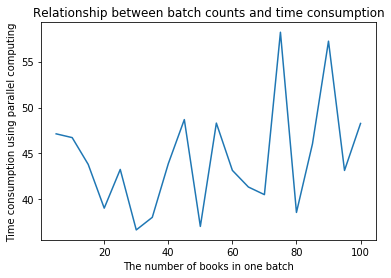

In [11]:
#Now plot this relationship between batch count and time consumption
import matplotlib.pyplot as plt

time_results = [i[1] for i in time_results_list]
plt.plot(batch_counts, time_results)
plt.xlabel("The number of books in one batch")
plt.ylabel("Time consumption using parallel computing")
plt.title("Relationship between batch counts and time consumption")